In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np

from summer.utils import ref_times_to_dti

from autumn.settings import Region, Models
from autumn.models.covid_19.constants import AGEGROUP_STRATA, BASE_DATETIME
from autumn.tools.project import get_project, run_project_locally
from autumn.tools import inputs
from autumn.tools.inputs.mobility.queries import get_mobility_data
from autumn.tools.inputs.social_mixing.build_synthetic_matrices import build_synthetic_matrices

In [2]:
# Some variables that will stay constant in the cells below
age_integers = [int(group) for group in AGEGROUP_STRATA]
model = Models.COVID_19

In [3]:
# Create a function for plotting the populations
def summarise_population(project, region, axis):
    total_pops = inputs.get_population_by_agegroup(
        AGEGROUP_STRATA, 
        project.param_set.baseline["country"]["iso3"],
        project.param_set.baseline["population"]["region"], 
        year=project.param_set.baseline["population"]["year"]
    )
    axis.bar(age_integers, total_pops, width=4)
    axis.set_title(f"{region}, population {round(sum(total_pops) / 1e6, 3)} million")

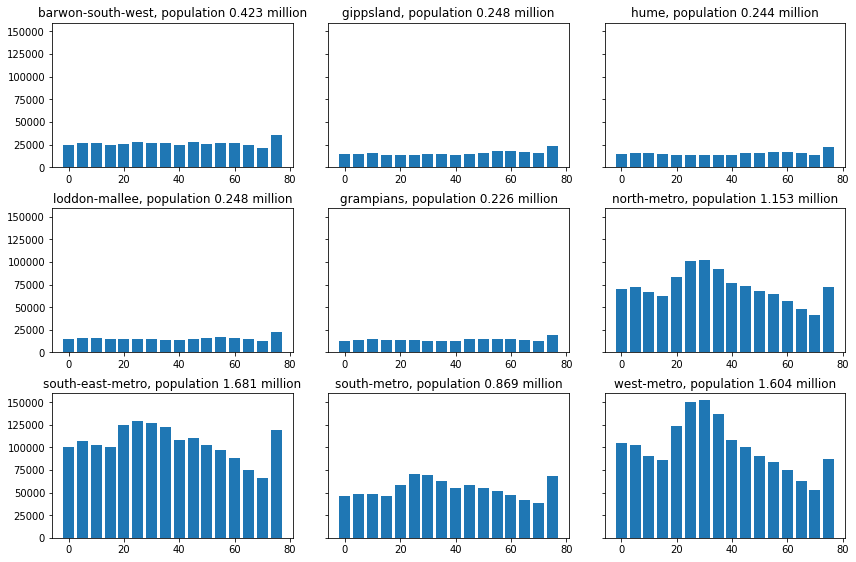

In [4]:
# Plot the populations
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey="all")
fig.tight_layout(pad=2)

for i_ax, ax in enumerate(axes.reshape(-1)):
    region = Region.VICTORIA_SUBREGIONS[i_ax]
    project = get_project(model, region)
    summarise_population(project, region, ax)

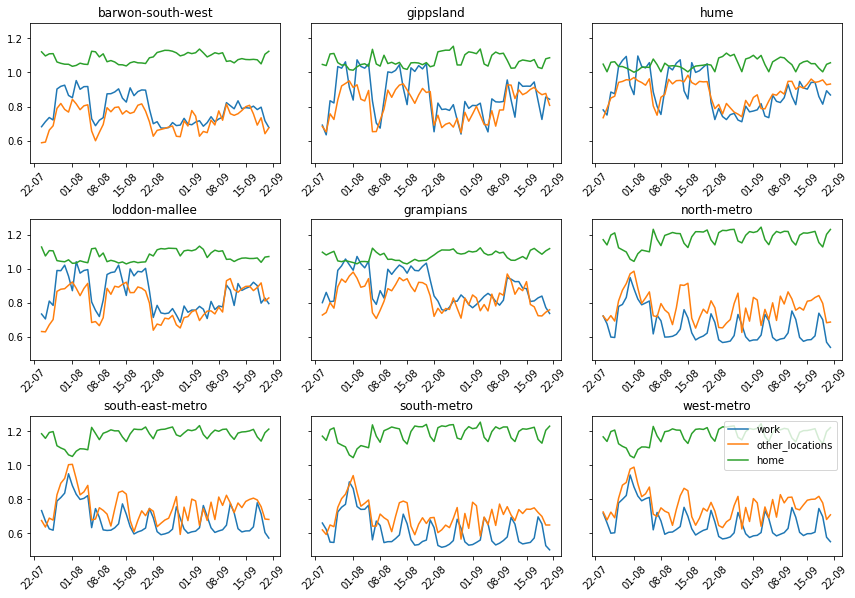

In [5]:
# Plot the mobility inputs to the model over recent weeks/months
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey="all")
fig.tight_layout(w_pad=1.5, h_pad=3.5)

for i_ax, ax in enumerate(axes.reshape(-1)):
    region = Region.VICTORIA_SUBREGIONS[i_ax]
    project = get_project(model, region)

    mobility_values, mobility_days = get_mobility_data(
        project.param_set.baseline["country"]["iso3"], 
        project.param_set.baseline["population"]["region"], 
        BASE_DATETIME, 
        project.param_set.baseline["mobility"]["google_mobility_locations"],
    )

    data_period = 60
    times = ref_times_to_dti(BASE_DATETIME, mobility_days[-data_period:])

    locations = project.param_set.baseline["mobility"]["google_mobility_locations"].keys()
    for location in locations:
        ax.plot(times, mobility_values[location][-data_period:], label=location)
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_title(region)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))

ax.legend(loc="upper right")


For cluster: barwon-south-west
	Modelled country: AUS
	Modelled sub-region: BARWON_SOUTH_WEST
	Proxy country: GBR
	Whether age adjusted: True

For cluster: gippsland
	Modelled country: AUS
	Modelled sub-region: GIPPSLAND
	Proxy country: GBR
	Whether age adjusted: True

For cluster: hume
	Modelled country: AUS
	Modelled sub-region: HUME
	Proxy country: GBR
	Whether age adjusted: True

For cluster: loddon-mallee
	Modelled country: AUS
	Modelled sub-region: LODDON_MALLEE
	Proxy country: GBR
	Whether age adjusted: True

For cluster: grampians
	Modelled country: AUS
	Modelled sub-region: GRAMPIANS
	Proxy country: GBR
	Whether age adjusted: True

For cluster: north-metro
	Modelled country: AUS
	Modelled sub-region: NORTH_METRO
	Proxy country: GBR
	Whether age adjusted: True

For cluster: south-east-metro
	Modelled country: AUS
	Modelled sub-region: SOUTH_EAST_METRO
	Proxy country: GBR
	Whether age adjusted: True

For cluster: south-metro
	Modelled country: AUS
	Modelled sub-region: SOUTH_ME

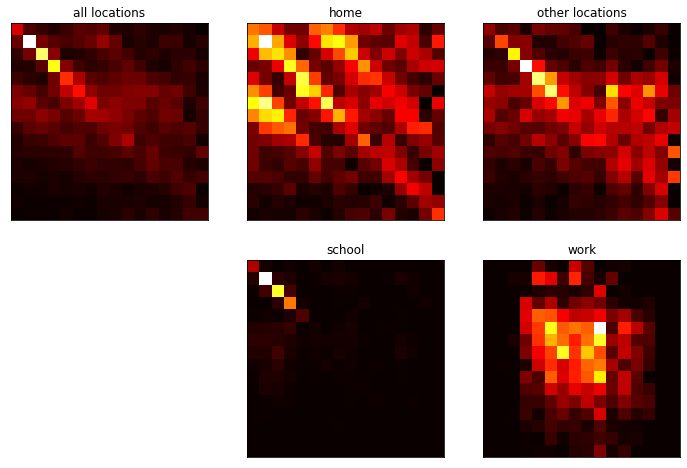

In [28]:
# Plot the mixing matrix being used
for region in Region.VICTORIA_SUBREGIONS:
    project = get_project(model, region)
    print(f"\nFor cluster: {region}")
    print(f"\tModelled country: {project.param_set.baseline['country']['iso3']}")
    print(f"\tModelled sub-region: {project.param_set.baseline['population']['region']}")
    print(f"\tProxy country: {project.param_set.baseline['mixing_matrices']['source_iso3']}")
    print(f"\tWhether age adjusted: {project.param_set.baseline['mixing_matrices']['age_adjust']}")
mixing_matrix = build_synthetic_matrices(
    project.param_set.baseline["country"]["iso3"],
    project.param_set.baseline["mixing_matrices"]["source_iso3"],
    AGEGROUP_STRATA,
    project.param_set.baseline["mixing_matrices"]["age_adjust"],
    project.param_set.baseline["population"]["region"]
)

fig = plt.figure(figsize=(12, 8))
positions = [1, 2, 3, 5, 6]
for i_loc, location in zip(positions, mixing_matrix.keys()):
    ax = fig.add_subplot(2, 3, i_loc)
    ax.imshow(
        np.flipud(np.transpose(mixing_matrix[location])), 
        cmap=cm.hot, 
        vmin=0,
        vmax=mixing_matrix[location].max(), 
        origin="lower"
    )
    ax.set_title(location.replace("_", " "))
    ax.set_xticks([])
    ax.set_yticks([])